# Exercise 5
## Fundamentals of Machine Learning, WiSe 20/21
### Authors: Catherine Knobloch, Elias Olofsson, Julia Siegl
    Version information:
        2021-01-26: v.1.0. First public release. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')
from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr

## 3 - Constructing the matrix X (25 pts)

In [2]:
def construct_X(M, alphas, Np=None):
    '''
    Construct the matrix X of weights corresponding to the linear system of equations
    X*Beta = y, where Beta and y are vectors.
    
    Parameters
    ----------
    M: int
        One-sided length of the square tomogram. Full size of tomogram is D = M*M. 
    alphas: list
        List of measurement angles alpha, in degrees.
    Np: int
        Resolution of sensor array, optional.
    Returns:
    --------
    scipy.sparse.coo.coo_matrix 
        The constructed matrix X in sparse format.
    '''
    # Pixel spacing in tomography image and in sensor array.
    h = 1  
    
    # If no sensor resolution is given, set a large enough value to cover image.
    if Np == None:
        Np = np.ceil(np.sqrt(2)*M)
    
    D = int(M*M)               # Pixel count in tomography image.
    N = int(Np * len(alphas))  # Number of measured responses y_i.
    
    # Convert angles to radians.
    alphas_rad = np.radians(alphas) 
    
    # Construct unit vectors from the alphas.
    n = np.array([np.cos(alphas_rad), -np.sin(alphas_rad)]) # shape=(2,len(alphas))
    
    # Geometrical center of tomography image.
    geo_center = (M/2 - 0.5)*h           
    
    # Construct matrix with center coordinates for all pixels.
    linpos = h*np.arange(M) - geo_center             # 1D position vector.
    x_pos, y_pos = np.meshgrid(linpos, linpos)       # 2D meshgrid.
    C = np.array([x_pos.flatten(), y_pos.flatten()]) # Pixel centers, shape=(2,D).
    
    # Distance from first element in sensor to sensor origin.
    s0 = (Np/2 - 0.5)*h 
    
    # Find the pixel projections on the sensor.
    p = (n.T @ C) + s0 
    
    # Matrices of indices. 
    p_idx = np.indices(p.shape)
    
    # Pixel index j from where ray originates. 
    j_low  = p_idx[1]
    j_high = p_idx[1]
    
    # Sensor indices i where ray intersects sensor array. 
    i_low  = np.floor(p/h) + p_idx[0] * Np
    i_high = np.ceil(p/h)  + p_idx[0] * Np
    
    # Fractional coverage of ray from pixel j at sensor i.
    weights_high = p/h - np.floor(p/h)
    weights_low  = 1 - weights_high
    
    # Concatenate arrays.
    i_idx   = np.concatenate((i_low.flatten(), i_high.flatten()))
    j_idx   = np.concatenate((j_low.flatten(), j_high.flatten()))
    weights = np.concatenate((weights_low.flatten(), weights_high.flatten()))
    
    # Convert to integer datatype.
    i_idx = i_idx.astype(int)
    j_idx = j_idx.astype(int)
    
    # Form sparse matrix.
    X = coo_matrix((weights, (i_idx, j_idx)), shape=(N,D), dtype=np.float32)
    
    return X

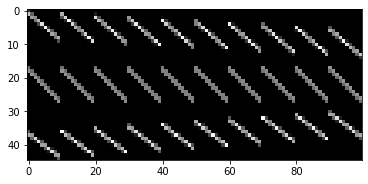

In [3]:
# Testing the constructor routine.
X = construct_X(10, [-33, 1, 42])
plt.imshow(X.todense())
plt.show()

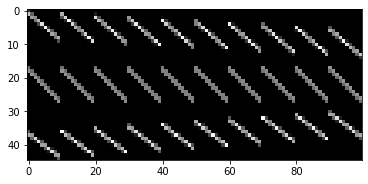

In [4]:
# Comparison with the included pre-computed example.
X_ex = np.load('hs_tomography/X_example.npy')
plt.imshow(X_ex)
plt.show()

## 4 - Recovering the image (6 pts)

Loading in the tomography data.

In [5]:
# Lower resolution image
M_77      = 77
Np_77     = 109
alphas_77 = np.load('hs_tomography/alphas_77.npy')
y_77      = np.load('hs_tomography/y_77.npy')

# Higher resolution image
M_195      = 195
Np_195     = 275
alphas_195 = np.load('hs_tomography/alphas_195.npy')
y_195      = np.load('hs_tomography/y_195.npy')

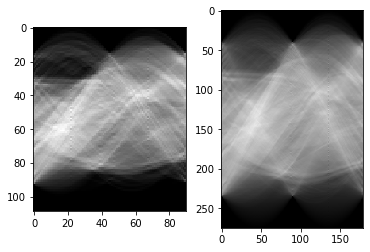

In [6]:
# Visualizing the sinograms, just for fun. 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(y_77.reshape(len(alphas_77),Np_77).T)
ax2.imshow(y_195.reshape(len(alphas_195),Np_195).T)
plt.show()

In [7]:
# Generating the X-matrices.
X_77  = construct_X(M_77 , alphas_77 , Np=Np_77)
X_195 = construct_X(M_195, alphas_195, Np=Np_195)

In [8]:
# Converting COO-matrices to CSC-format
X_77  = X_77.tocsc()
X_195 = X_195.tocsc()

In [9]:
# Solving for Beta, for the lower resolution image.
beta_77, istop, itn, r1norm = lsqr(X_77, y_77)[:4]
print(istop, itn, r1norm)

1 7934 0.320710566643974


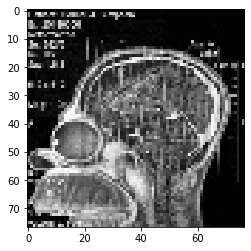

In [10]:
# Plotting the resulting X-ray image.
plt.imshow(beta_77.reshape(M_77, M_77))
plt.show()

In [11]:
# Solving for Beta, for the higher resolution image.
beta_195, istop, itn, r1norm = lsqr(X_195, y_195, atol=5e-07, btol=5e-07)[:4]
print(istop, itn, r1norm)

1 1793 45.28904041678663


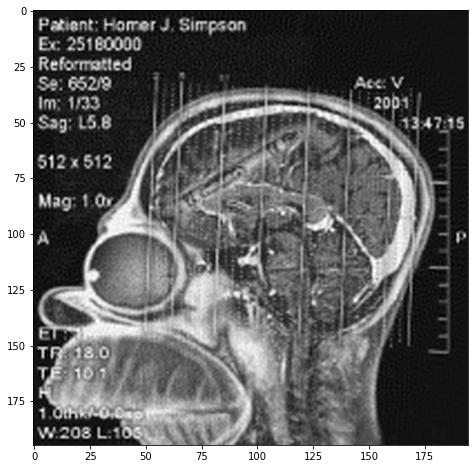

In [12]:
# Plotting the resulting X-ray image.
plt.figure(figsize=(8,8))
plt.imshow(beta_195.reshape(M_195, M_195),interpolation = "spline36")
plt.show()

I think Mr. H. Simpson might do well if the crayon in his brain is removed.

## 5 - Minimizing the radiation dose (9 pts) 

We first try reducing the radiation dose by selecting every second angle. Since the angles are listed in increasing order, we thus ensure that we have enough separation between the projections such that the linear system of equations remain well-posed.

1 1720 30.649548238977456


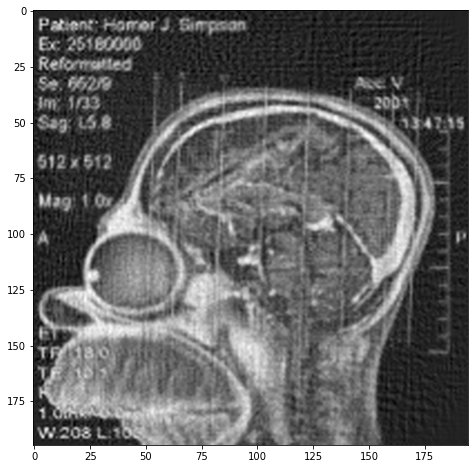

In [13]:
# Selecting every second angle.
step = 2

# Get new list of alphas and new vector y.
alphas_195_red = alphas_195[0::step]
y_195_red      = y_195.reshape(len(alphas_195),Np_195)[0::step].flatten()

# Get new X-matrix.
X_195_red = construct_X(M_195, alphas_195_red, Np=Np_195)

# Convert to CSC format.
X_195_red = X_195_red.tocsc()

# Solving for Beta, for the higher resolution image.
beta_195_red, istop, itn, r1norm = lsqr(X_195_red, y_195_red, atol=5e-07, btol=5e-07)[:4]
print(istop, itn, r1norm)

# Plotting the resulting X-ray image.
plt.figure(figsize=(8,8))
plt.imshow(beta_195_red.reshape(M_195, M_195),interpolation = "spline36")
plt.show()

We have lost a lot of clarity from above, but still the head and the crayon can be resolved. Let's continue further and select every third angle.

1 1552 23.761694302593984


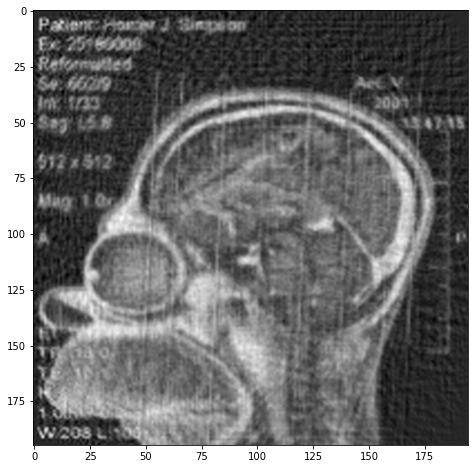

In [14]:
# Selecting every third angle.
step = 3

# Get new list of alphas and new vector y.
alphas_195_red = alphas_195[0::step]
y_195_red      = y_195.reshape(len(alphas_195),Np_195)[0::step].flatten()

# Get new X-matrix.
X_195_red = construct_X(M_195, alphas_195_red, Np=Np_195)

# Convert to CSC format.
X_195_red = X_195_red.tocsc()

# Solving for Beta, for the higher resolution image.
beta_195_red, istop, itn, r1norm = lsqr(X_195_red, y_195_red, atol=5e-07, btol=5e-07)[:4]
print(istop, itn, r1norm)

# Plotting the resulting X-ray image.
plt.figure(figsize=(8,8))
plt.imshow(beta_195_red.reshape(M_195, M_195),interpolation = "spline36")
plt.show()

Now we are starting to seriously lose image quality. The crayon is barely visible, and all inner structures of the head can hardly be resolved. Let's continue.  

1 1520 20.64812596124281


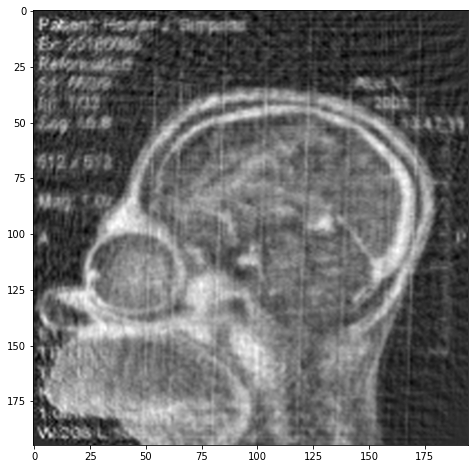

In [15]:
# Selecting every fourth angle.
step = 4

# Get new list of alphas and new vector y.
alphas_195_red = alphas_195[0::step]
y_195_red      = y_195.reshape(len(alphas_195),Np_195)[0::step].flatten()

# Get new X-matrix.
X_195_red = construct_X(M_195, alphas_195_red, Np=Np_195)

# Convert to CSC format.
X_195_red = X_195_red.tocsc()

# Solving for Beta, for the higher resolution image.
beta_195_red, istop, itn, r1norm = lsqr(X_195_red, y_195_red, atol=5e-07, btol=5e-07)[:4]
print(istop, itn, r1norm)

# Plotting the resulting X-ray image.
plt.figure(figsize=(8,8))
plt.imshow(beta_195_red.reshape(M_195, M_195),interpolation = "spline36")
plt.show()

Now we are well past of what is useful. Now the image is of so low quality that nobody would be reasonable able to draw any delicate medical conclusions from this alone.

However, as we saw above, only selecting every second angle maintains a lot of the image quality while effectivley cutting the radiation dose in half. One could also experiment further by selecting 2/3 of the angles instead, and most likely retain an even better image quality than this.